Questions-
- Should I plot the errors associated with each point as error bars on top of the GPR STD cloud?
- Is there a way to change the prior from flat in this example?
- What are methods for testing the accuracy of the GPR?

In [271]:
import numpy as np
import matplotlib.pyplot as plt

In [272]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [273]:
#First, we will do the plotting demo that shows the prior and posterior ... but for Arnold Data
# This one also does the kernel optimization junk 

In [274]:
def separate_data(data):#function for separating data 
    '''
    input: data as 4 collom array
    output: 4 separated vectors based on collum
    

    '''

    lines = data.strip().split('\n')
    COM = []
    COMerror = []
    sfactor = []
    sfactorerror = []

    for line in lines:
        parts = line.split()
        COM.append(float(parts[0]))
        COMerror.append(float(parts[1]))
        sfactor.append(float(parts[2]))
        sfactorerror.append(float(parts[3]))

    return COM, COMerror, sfactor, sfactorerror

In [275]:
#Here, put training data 
training_data = """ 
0 0 0 0 
0.0089763  75.0e-6     13.340  0.026700
0.027000   75.0e-6     19.920  0.019920
0.046650   75.0e-6     27.489  0.027489
0.061395   75.0e-6     24.593  0.024593
0.067373   75.0e-6     22.002  0.022002


"""


In [276]:
# Call separate_data function and unpack the returned tuples
arnoldCOM, arnoldCOMerror, arnoldsfactor, arnoldsfactorerror = separate_data(training_data)

In [277]:
#function to plot the prior and posterior - from scikitlearn 
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    
    #prediction data - make it the correct size and shape for the example 
    x = np.linspace(0, 0.2, 100)
    X = x.reshape(-1, 1)

    #calculate mean and std based off prediction data 
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.2,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")


In [278]:
#declare x_train
X_train = np.array(arnoldCOM).reshape(-1,1)

#declare y_train 
y_train = np.array(arnoldsfactor).reshape(-1,1)

#define amount of sample functions 
n_samples = 5

In [279]:
#define kernel prior to optimization 
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel parameters before fit:
1**2 * RBF(length_scale=1))
Kernel parameters after fit: 
316**2 * RBF(length_scale=0.1) 
Log-likelihood: -10971.682


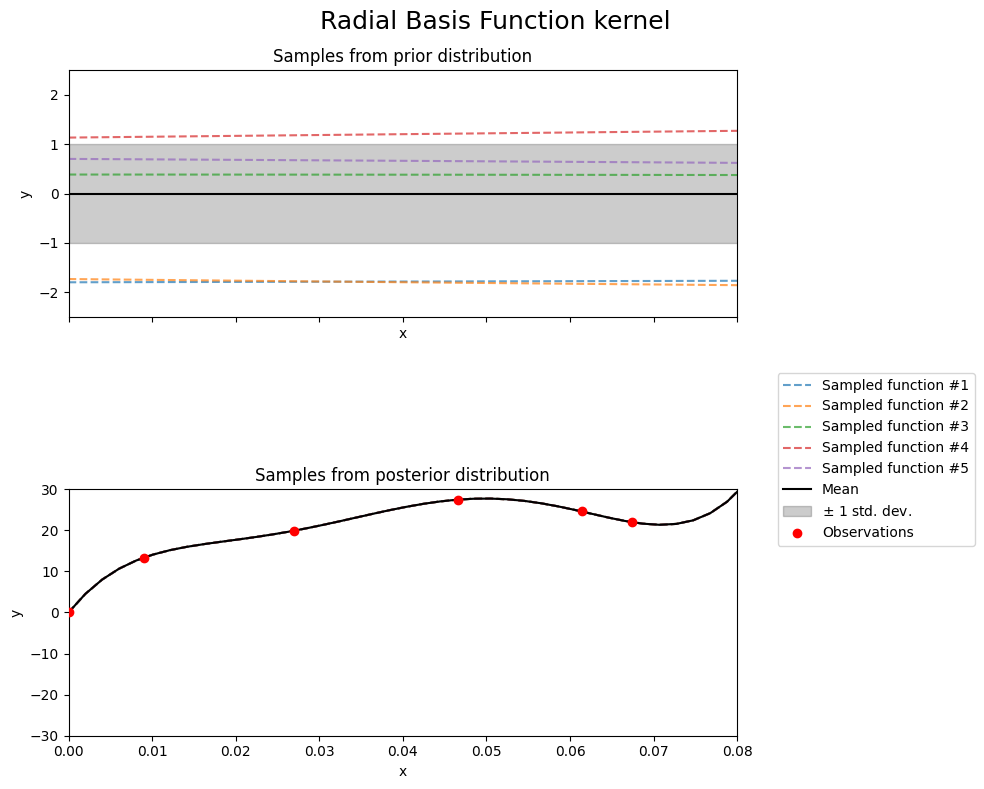

In [280]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[0])
axs[0].set_title("Samples from prior distribution")
axs[0].set_ylim([-2.5,2.5])
axs[0].set_xlim([0,0.1])

# plot posterior
gpr.fit(X_train, y_train)
plot_gpr_samples(gpr, n_samples=n_samples, ax=axs[1])
axs[1].scatter(X_train[:, 0], y_train, color="red", zorder=100, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")
axs[1].set_ylim([-30,30])
axs[1].set_xlim([0,0.08])

fig.suptitle("Radial Basis Function kernel", fontsize=18)
plt.tight_layout()
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}"
)